## K Nearest Neighbors (KNN) o K Vecinos más Cercanos

Este algoritmo cuyo nombre puede ser traducido como K Vecinos más Cercanos puede ser utilizado para resolver problemas de clasificación (aprendizaje supervisado) o de regresión/clusterización (aprendizaje no supervisado).

Para un ejemplo supervisado podemos revisar el notebook previo (Precisión vs Cobertura) en donde el dataset empleado cuenta con un atributo o columna que representa a una variable categórica (tipo Factor en R). En esta ocasión abordaremos un problema de regresión, "clusterización" o de aprendizaje no supervisado.

Primero cargamos las bibliotecas y el dataset que será utilizado.

In [ ]:
#Loading libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Dataset

El dataset con el que trabajaremos, consta de únicamente variables o atributos numéricos (más allá de si son discretos o continuos). Las variables de input o independientes serán la altura y la edad, mientras que nuestra variable a predecir o target será el peso. Es importante mencionar que la naturaleza de la variable de target determina si el problema de aprendizaje es de regresión o de clasificación, por lo que un dataset en donde tuviéramos atributos categóricos y quisieramos predecir una variable numérica igualmente caería en la categoría de no supervisado.

**OBSÉRVESE QUE EN LA ÚLTIMA FILA SE TIENE UNA OBSERVACIÓN CUYO PESO ES DESCONOCIDO**

In [ ]:
# Loading datasets
db = pd.read_csv("datasets/alturas_pesos.csv")
db

,ALTURA,EDAD,PESO
0,5.00,45,77.0
1,5.11,26,47.0
2,5.60,30,55.0
3,5.90,34,59.0
4,4.80,40,72.0
5,5.80,36,60.0
6,5.30,19,40.0
7,5.80,28,60.0
8,5.50,23,45.0
9,5.60,32,58.0


A continuación separamos nuestro dataset en un conjunto de entrenamiento constituido por las primeras 10 filas y un conjunto de prueba que cuenta únicamente con una observación. En este ejemplo concreto este paso en realidad es simbólico ya que lo que se quiere mostrar es cómo el algoritmo predice valores numéricos.

In [ ]:
prediction = db.iloc[10,:]
data = db.iloc[0:10,:]
train = data.iloc[0:7,:]
test = data.iloc[7:10,:]
x = train['ALTURA']
y = train['EDAD']
labels = train['PESO']

Si graficamos nuestros datos podremos observar cómo se distribuyen las observaciones en el espacio N-Dimensional de atributos o variables independientes. Por otra parte podemos observar el punto amarillo que representa la observación cuyo valor de peso deseamos estimar.

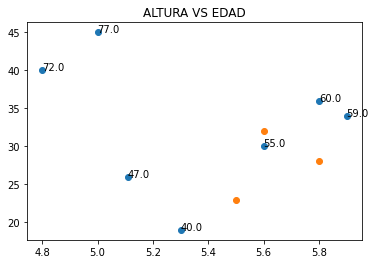

In [ ]:
fig,ax = plt.subplots()
ax.set_title("ALTURA VS EDAD")
ax.scatter(x,y)
ax.scatter(test['ALTURA'],test['EDAD'])
for i,label in enumerate(labels):
    ax.annotate(label, (x[i],y[i]), )
plt.show()

## Supuesto:
El supuesto más importante de KNN puede resumirse en que "observaciones cercanas en el espacio de atributos tienen una valor similar en la variable de target". Dicho supuesto da pie a que consideremos:

1. Una medida de distancia que nos permita definir "cercano" mediante el establecimiento de un umbral (en este caso esto se controla mediante el valor de K)
2. Un criterio para una vez dado este "radio" observar a los veciones dentro del mismo y determinar el valor de target que la observación objetivo debe de tener.

### 1. Calculando la distancia del punto objetivo a los demás puntos

El primer paso consiste en definir una medida de distancia para medir la cercanía de un punto a sus vecinos. 

Algunas medidas de distancia comúnmente empleadas son la distancia euclidiana, la distancia Manhattan (ambas conocidas como Distancia de orden 2 y Distancia de orden 1 de Minkowsky respectivamente), la distancia de Hamming o la distancia de Jaccard (estas últimas dos son de suma utilidad en Procesamiento del Lenguaje Natural).

**Distancia euclidiana (Distancia 2 de Minkowsky)**

$d(\vec{x},\vec{y})~=~\sum\sqrt{|x_i-y_i|}~=~\sum(|x_i-y_i|)^{1\over2}$

**Distancia Manhattan (Distancia 1 de Minkowsky)**

$d(\vec{x},\vec{y})~=~\sum|x_i-y_i|~=~\sum(|x_i-y_i|)^{1\over1}$

**Distancia de Hamming (para variables categóricas)**

$d(\vec{x},\vec{y})~=~\sum{h_i}$

donde $~h_i=0~$ si $~x_i=y_i~$ y $~h_i=1~$ si $~x_i\neq y_i~$

**Distancia de Jaccard (para variables categóricas, palabras o conjuntos, puede aplicarse a vectores o conjuntos de distinto tamaño)**

$d(X,Y)~=~1-$${|X\bigcap Y|}\over{|X\bigcup Y|}$

A continuación procederemos a calcular las 2 primeras distancias mencionadas para aplicar el algoritmo y notar sus diferencias (¿pueden calcularse las segundas 2 distancias en este data set?, ¿si no se puede, podrías hacer algo para que se pudiera?):

In [ ]:
train_input = train.iloc[:,0:2].to_numpy()
test_input = test.iloc[0,0:2].to_numpy().reshape(1,-1)

dist_eucl = [np.linalg.norm(test_input-train_point) for train_point in train_input]
dist_manh = manhattan_distances(test_input,train_input)[0]

df = pd.DataFrame(list(zip(dist_eucl, dist_manh)), 
               columns =['EUCLIDEAN', 'MANHATTAN']) 
df.describe()

,EUCLIDEAN,MANHATTAN
count,7.000000,7.000000
mean,8.028682,8.470000
std,5.372739,5.585544
min,2.009975,2.200000
25%,4.058256,4.395000
50%,8.000000,8.000000
75%,10.527736,11.250000
max,17.018813,17.800000


## Ya que tenemos las distancias computadas, ¿cómo decidimos el valor de K?

Para elegir el valor de k óptimo podemos utilizar la tasa de error obtenida sobre el conjunto de prueba, para así elegir aquella donde encontremos el valor más pequeño. Para esto aplicaremos el algoritmo probando varios valores de k y en función de ello determinaremos aquella que minimice el error en el conjunto de prueba.


In [ ]:
x_train = train.drop('PESO', axis=1)
y_train = train['PESO']

x_test = test.drop('PESO', axis=1)
y_test = test['PESO']

scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

rmse_val = [] #to store rmse values for different k
for K in range(7):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  # fit the model
    pred=model.predict(x_test) # make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) # calculate RMSE (Residuals Mean Squared Error)
    rmse_val.append(error) #store RMSE 
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 11.045361017187261
RMSE value for k=  2 is: 9.569918146637061
RMSE value for k=  3 is: 8.24845664576332
RMSE value for k=  4 is: 7.275816105427624
RMSE value for k=  5 is: 9.178235124467014
RMSE value for k=  6 is: 8.349428900407677
RMSE value for k=  7 is: 7.885662525710046


<AxesSubplot:>

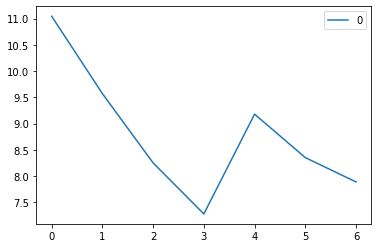

In [ ]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

Con base en la gráfica anterior podemos concluir que el valor de K que minimiza el MSE es K = 3. Ahora procederemos a construir el modelo para esta K y predeciremos la observación faltante en el dataset original.

In [ ]:
prediction

ALTURA     5.5
EDAD      38.0
PESO       NaN
Name: 10, dtype: float64

In [ ]:
model = KNeighborsRegressor(n_neighbors = 3)
model.fit(data.iloc[:,0:2],data.iloc[:,2])# Data not rescaled
model.predict(prediction[0:2].to_numpy().reshape(1,-1))

array([63.66666667])

Por lo que recordando los datos originales tendríamos que para una persona de 5.50 ft de altura y 38 años su peso estimado sería de 63.67 kg.

In [ ]:
db

,ALTURA,EDAD,PESO
0,5.00,45,77.0
1,5.11,26,47.0
2,5.60,30,55.0
3,5.90,34,59.0
4,4.80,40,72.0
5,5.80,36,60.0
6,5.30,19,40.0
7,5.80,28,60.0
8,5.50,23,45.0
9,5.60,32,58.0


## ¿Cómo predice (variable numérica) o clasifica (variable categórica) KNN?

Si estamos ante un problema de regresión o de aprendizaje no supervisado KNN utiliza a los K vecinos más cercanos para utilizar el valor que presentan en la variable target y mediante un promedio asignar el valor correpondiente a la nueva observación. 

**OBSERVACIÓN: Podríamos utilizar la mediana en lugar del promedio dependiendo de la distribución de los K datos considerados.**

Si estamos ante un problema de clasificación o de aprendizaje supervisado KNN asigna por democracia el valor de la variable target, o la categoría, esto lo hace considerando la moda obtenida al considerar a los K vecinos más cercanos y observar la categoría a la que pertenece cada uno.

Ahora bien pensando en el problema antes presentado ¿convendría pensar en otros métodos de regresión o estimación? 

La regresión lineal clásica puede brindar un método con el cual contrastar los resultados del modelo anterior. Recordemos que encontramos un MSE para K = 3, por lo que podríamos conocer el MSE obtenido mediante un modelo de regresión lineal clásico y ver en qué caso obtenemos un valor menor. Sin embargo dicho método lo veremos en un siguiente notebook.